# Lecture 4 - (continued) Polynomial Curve Fitting & Experimental Design

Last class, we have determined all steps for training a Polynomial Regression model.

We have also implemented this model in Python and fitted a polynomial curve onto a noisy sine curve.

## Polynomial Curve Fitting

Suppose our data comes from a noisy sinusoidal: $t = \sin(2\pi x) + \epsilon$ where $\epsilon$ is a (univariate) Gaussian zero-mean random noise. 

* The input samples are $x$
* The desired values are $t + \epsilon$, but we know that $t = \sin(2\pi x)$
* Our **goal** is to find a model that fits the set of data samples $\{x_i,t_i\}_{i=1}^N$
* We also want our model to be able to correctly **predict** the desired value of a new data sample $x_{test}$

Let's generate data from the *true* underlying function, $t=\sin(2\pi x)$, which, in practice, we would not know.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

In [2]:
def NoisySinusoidalData(N, a, b, gVar):
    x = np.linspace(a,b,N)
    noise = npr.normal(0,gVar,N)
    t = np.sin(2*np.pi*x) + noise
    return x, t

In [3]:
N = 40
Ntest = 10 
a, b = [0,1] 
gVar_train = 0.5 
gVar_test = 1 
x1, t1 = NoisySinusoidalData(N, a, b, gVar_train)    # training data and labels
x2, t2 = NoisySinusoidalData(N, a, b, 0)             #true sine function
x3, t3 = NoisySinusoidalData(Ntest, a, b, gVar_test) # test data and labels

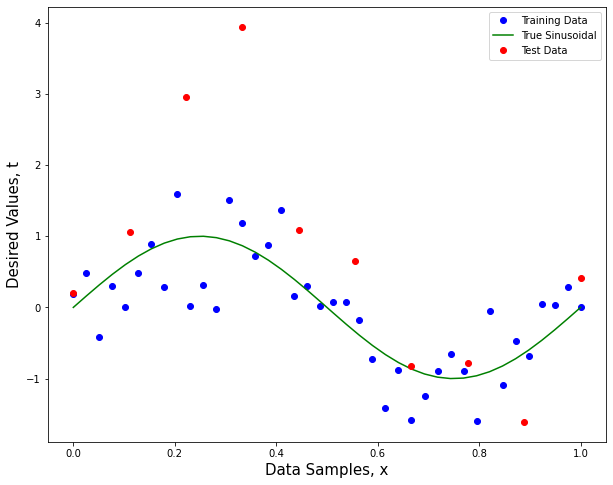

In [4]:
plt.figure(figsize=(10,8))
plt.plot(x1, t1, 'bo', label = 'Training Data')
plt.plot(x2, t2, 'g', label = 'True Sinusoidal')
plt.plot(x3, t3, 'ro', label = 'Test Data')
plt.legend()
plt.xlabel('Data Samples, x', fontsize=15)
plt.ylabel('Desired Values, t', fontsize=15);

## Recap on Training Stage steps for Polynomial Regression

**Training Stage**

1. **Input Space.** Collect training data: $\{x_i,t_i\}_{i=1}^N$

2. **Feature Space.** Extract polynomial features for some model order $M$: $\phi(x_i) = [x_i^0,x_i^1,\dots,x_i^M]^T, \forall i=1,\dots,N$
    * We can create a **feature matrix**, $\mathbf{X}$, where we stack each data point's feature representation in rows. $\mathbf{X}$ is a $N\times (M+1)$ matrix.

3. **Model Selection.** The linear regression model can be written in a linear functional form:
$$\mathbf{y} = f(\mathbf{w},\mathbf{x}) = w_0\mathbf{x}^0 + w_1\mathbf{x}^1 + \dots + w_M\mathbf{x}^M$$

where $\mathbf{w}=[w_0,w_1,\dots,w_M]^T$ are unknown coefficients (or parameters) of the model.

We can rewrite the model in matrix-vector notation:
    
$$\mathbf{y} = f(\mathbf{w},\mathbf{x}) =\mathbf{X}\mathbf{w}$$

4. **Objective (or cost or loss) Function.** Determine an objective function that allows us to evaluate the fitted model. We can use:
$$\text{Least Squares: } J(\mathbf{w}) = \sum_{i=1}^N e_i^2 = \sum_{i=1}^N \left(t_i-y_i\right)^2$$
$$\text{Least Mean Squares (LMS): } J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N e_i^2 = \frac{1}{N}\sum_{i=1}^N \left(t_i-y_i\right)^2$$
$$\text{L1-norm: } J(\mathbf{w}) = \sum_{i=1}^N |e_i| = \sum_{i=1}^N \left|t_i-y_i\right|$$
$$\text{and many others ...}$$ 

where $e_i = t_i - y_i$.
    * The most common objective function is the LMS as it (1) will not depend on the number of samples, and (2) it is easy to take derivatives and find a closed-form solution for the parameters $\mathbf{w}$.

5. **Learning Algorithm**. The learning algorithm is an *optimization algorithm*, it poses the problem as

$$\arg_{\mathbf{w}} \min J(\mathbf{w},\mathbf{x})$$

It will *search* the objective function to find the *optimal* set of parameters $\mathbf{w^*} = [w_0^*,w_1^*,\dots,w_M^*]^T$ that **minimize** the objective function $J(\mathbf{w})$. When using the Least Squares or the LMS objective function, the *optimal* solution for the parameters $\mathbf{w}$ is given by:

$$\mathbf{w}^* = \left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{t}$$

With this we have just **trained the model**!

In [5]:
def PolynomialRegression(x,t,M):
    X = np.array([x**m for m in range(M+1)]).T
    w = np.linalg.inv(X.T@X)@X.T@t
    y = X@w
    error = t-y
    return w, y, error

0.17453812120125373


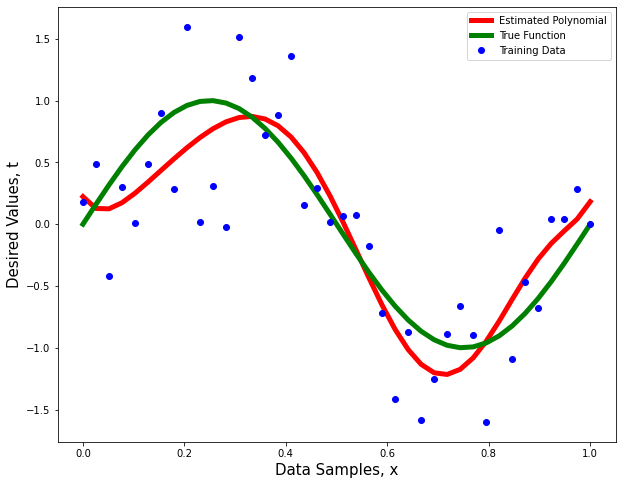

In [13]:
M = 8

w, y, error = PolynomialRegression(x1,t1,M) 

plt.figure(figsize=(10,8))
plt.plot(x1,y,'r', label = 'Estimated Polynomial', linewidth=5)
plt.plot(x2,t2,'g', label = 'True Function', linewidth=5)
plt.plot(x1,t1,'bo', label='Training Data')
plt.legend()
plt.xlabel('Data Samples, x', fontsize=15)
plt.ylabel('Desired Values, t', fontsize=15);

print(np.sum(error**2)/N)

### Observations

* What happens when the polynomial model order $M$ increases/decreases?

* How large/small do the weight parameter values are as we increase $M$? Could this information be useful?

* Which model order $M$ works best? Which $M$ would you choose?

## Testing Stage

We have generated test data. In this synthetic environment, we have the label values for the test samples. But in practice, we will **not** have labels for the test data.

**Testing Stage**

1. **Data acquisition.** In real world scenario, you will have samples coming in to the system for which the model will make a prediction for the desired response.

2. **Extract (same) features.** We will extract the same features as in the training stage, i.e., if we *fit* a model of polynomial order $M=3$, then we need to extract a 3rd-degree polynomial representation for every sample in the test set.

In [15]:
Xtest = np.array([x3**m for m in range(M+1)]).T

Xtest.shape

(10, 9)

3. **Predict Labels.** In this step, we will use the trained model (the vector of coefficients $\mathbf{w}^*$ and compute the predicted labels for the feature representation of the test samples.

In [16]:
def PolynomialRegression_test(x, M, w):
    X = np.array([x**m for m in range(M+1)]).T
    y = X@w
    return y

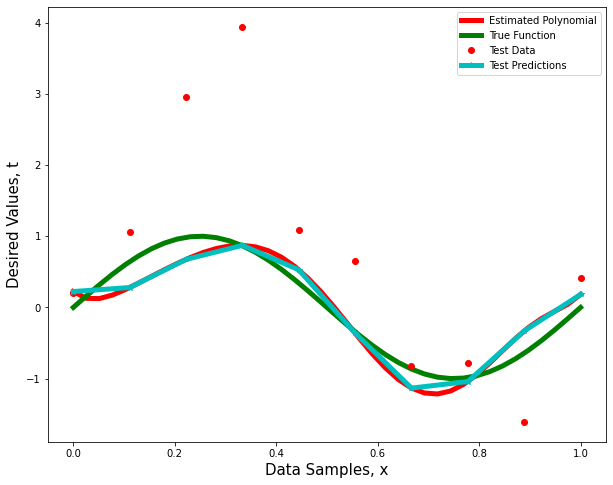

In [17]:
y_test = PolynomialRegression_test(x3, M, w)

plt.figure(figsize=(10,8))
plt.plot(x1,y,'r', label = 'Estimated Polynomial',linewidth=5)
plt.plot(x2,t2,'g', label = 'True Function',linewidth=5)
# plt.plot(x1,t1,'bo', label='Training Data')
plt.plot(x3,t3,'ro', label = 'Test Data')
plt.plot(x3,y_test,'-c*', label = 'Test Predictions', linewidth=5)
plt.legend()
plt.xlabel('Data Samples, x', fontsize=15)
plt.ylabel('Desired Values, t', fontsize=15);

### Observations:

* How did the trained model *fit* in the test data?
* Is it able to *generalize*? What does *generalization* even mean?
* Can we **design** a *training* strategy that can tells us how *well* we are performing in *unseen and unlabeled* data?

Let's put it all together:

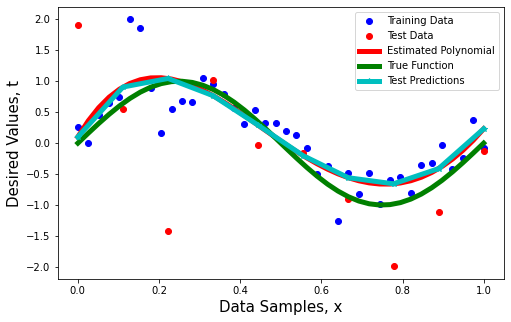

In [28]:
# Data Acquisition
N = 40
Ntest = 10 
a, b = [0,1] 
gVar_train = 0.5 
gVar_test = 1 
x1, t1 = NoisySinusoidalData(N, a, b, gVar_train)    # training data and labels
x2, t2 = NoisySinusoidalData(N, a, b, 0)             #true sine function
x3, t3 = NoisySinusoidalData(Ntest, a, b, gVar_test) # test data and labels

# Model parameters
M = 4

# Training and Test
w, y, error = PolynomialRegression(x1,t1,M) 
y_test = PolynomialRegression_test(x3, M, w)

# Visualization
plt.figure(figsize=(8,5))
plt.plot(x1,t1,'bo', label='Training Data')
plt.plot(x3,t3,'ro', label = 'Test Data')
plt.plot(x1,y,'r', label = 'Estimated Polynomial', linewidth=5)
plt.plot(x2,t2,'g', label = 'True Function', linewidth=5)
plt.plot(x3,y_test,'-c*', label = 'Test Predictions', linewidth=5)
plt.legend()
plt.xlabel('Data Samples, x', fontsize=15)
plt.ylabel('Desired Values, t', fontsize=15);

Let's compute the **LMS** cost function as a function of the model order $M$:

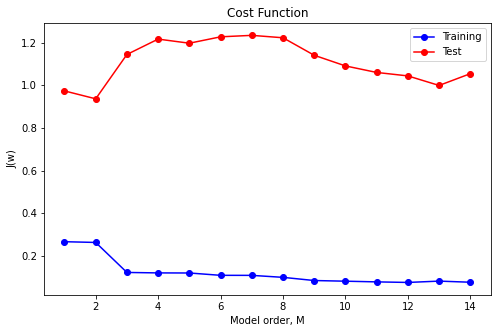

In [29]:
J_train = []
J_test = []
Mrange=15

for M in range(1,Mrange):
    w, y, error_training = PolynomialRegression(x1,t1,M)
    y_test = PolynomialRegression_test(x3, M, w)
    error_test = t3 - y_test
    J_train += [np.sum(error_training**2)/N]
    J_test += [np.sum(error_test**2)/Ntest]

fig = plt.figure(figsize=(8,5))
plt.plot(list(range(1,Mrange)),J_train,'bo-', label = 'Training')
plt.plot(list(range(1,Mrange)),J_test,'ro-', label = 'Test')
plt.title('Cost Function')
plt.legend()
plt.xlabel('Model order, M')
plt.ylabel('J(w)');

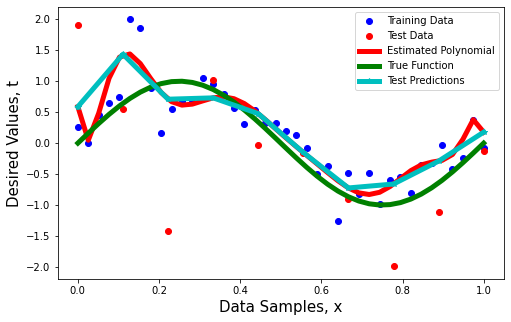

In [31]:
# Model parameters
M = 13

# Training and Test
w, y, error = PolynomialRegression(x1,t1,M) 
y_test = PolynomialRegression_test(x3, M, w)

# Visualization
plt.figure(figsize=(8,5))
plt.plot(x1,t1,'bo', label='Training Data')
plt.plot(x3,t3,'ro', label = 'Test Data')
plt.plot(x1,y,'r', label = 'Estimated Polynomial', linewidth=5)
plt.plot(x2,t2,'g', label = 'True Function', linewidth=5)
plt.plot(x3,y_test,'-c*', label = 'Test Predictions', linewidth=5)
plt.legend()
plt.xlabel('Data Samples, x', fontsize=15)
plt.ylabel('Desired Values, t', fontsize=15);

### Another Example

Let's predict beer wet foam height after time of pour for three different beer brands. 

* The [beer foam data set](http://www.stat.ufl.edu/~winner/datasets.html) was collected by A. Leike and published in their work titled "Demonstration of the Exponential Decay Law Using Beer Froth" in 2002.

**Goal:** use and optimize a linear regression that effectively *predicts* the wet foam height from different brands of beer after time of pour, using available information about that beer's previous foam height level at different times.

#### Data Set Description

The data contains measurements of wet foam height and beer height at various time points for 3 brands of beer. The author of this data set fit an *exponential decay model* of the form $H(t) = H_0 e^{-\lambda t}$.

The data set is saved as *.csv* file (**"beer_foam.csv"**) with information about the foam height (in cm) from 3 brands of beer over 15 measurement times (in seconds) after the time of pour.

The file is organized in 4 columns:
1. Time from pour (in seconds)
2. Erdinger Weissbier foam height (in cm)
3. Augustinerbrau Munchen foam height (in cm)
4. Budweiser foam height (in cm)

In [32]:
import pandas as pd

In [33]:
data = pd.read_csv('beer_foam.csv')

In [34]:
data

,Time,Erdinger,Augustinerbrau,Budweiser
0,0,17.0,14.0,14.0
1,15,16.1,11.8,12.1
2,30,14.9,10.5,10.9
3,45,14.0,9.3,10.0
4,60,13.2,8.5,9.3
5,75,12.5,7.7,8.6
6,90,11.9,7.1,8.0
7,105,11.2,6.5,7.5
8,120,10.7,6.0,7.0
9,150,9.7,5.3,6.2


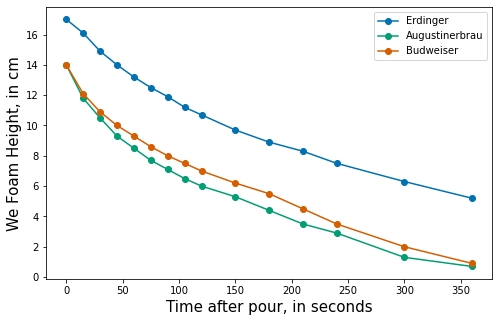

In [36]:
plt.figure(figsize=(8,5))

plt.plot(data['Time'], data['Erdinger'], '-o', label='Erdinger')
plt.plot(data['Time'], data['Augustinerbrau'], '-o', label='Augustinerbrau')
plt.plot(data['Time'], data['Budweiser'], '-o', label='Budweiser')
plt.legend()
plt.xlabel('Time after pour, in seconds', fontsize=15)
plt.ylabel('We Foam Height, in cm', fontsize=15);

Let's fit a **polynomial regression** model that predicts foam height for each brand of beer.

In [37]:
x = data['Time'].to_numpy() # input data

t = data[['Erdinger','Augustinerbrau','Budweiser']].to_numpy() #desired labels

In [38]:
x

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 150, 180, 210, 240,
       300, 360], dtype=int64)

In [39]:
t

array([[17. , 14. , 14. ],
       [16.1, 11.8, 12.1],
       [14.9, 10.5, 10.9],
       [14. ,  9.3, 10. ],
       [13.2,  8.5,  9.3],
       [12.5,  7.7,  8.6],
       [11.9,  7.1,  8. ],
       [11.2,  6.5,  7.5],
       [10.7,  6. ,  7. ],
       [ 9.7,  5.3,  6.2],
       [ 8.9,  4.4,  5.5],
       [ 8.3,  3.5,  4.5],
       [ 7.5,  2.9,  3.5],
       [ 6.3,  1.3,  2. ],
       [ 5.2,  0.7,  0.9]])

Let's compute the optimal set of parameters for the foam height model for each brand:

In [41]:
M = 3

w_erd, y_erd, e_erd = PolynomialRegression(x, t[:,0], M)
w_aug, y_aug, e_aug = PolynomialRegression(x, t[:,1], M)
w_bud, y_bud, e_bud = PolynomialRegression(x, t[:,2], M)

In [42]:
print('Coefficients for Erdinger model: w=',w_erd)
print('Coefficients for Augustinerbrau model: w=',w_aug)
print('Coefficients for Budweiser model: w=', w_bud)

Coefficients for Erdinger model: w= [ 1.69990652e+01 -7.32230661e-02  1.99726195e-04 -2.43910866e-07]
Coefficients for Augustinerbrau model: w= [ 1.33185634e+01 -9.34651108e-02  3.09252524e-04 -4.14722564e-07]
Coefficients for Budweiser model: w= [ 1.33771218e+01 -7.80529218e-02  2.37883684e-04 -3.31055859e-07]


**What is the predicted foam height at time $t=450$ seconds?**

In [43]:
erd_t450 = PolynomialRegression_test(450, M, w_erd)
aug_t450 = PolynomialRegression_test(450, M, w_aug)
bud_t450 = PolynomialRegression_test(450, M, w_bud)

print('At time t=450 s, the beer foam height predictions are:')
print('Erdinger : ',erd_t450, ' cm')
print('Augustinerbrau: ',aug_t450, ' cm')
print('Budweiser: ', bud_t450, ' cm')

At time t=450 s, the beer foam height predictions are:
Erdinger :  2.266862308056872  cm
Augustinerbrau:  -3.908693926936536  cm
Budweiser:  -3.742712167716494  cm


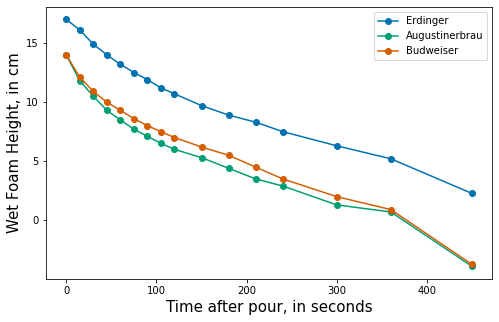

In [44]:
#To be complete in class...
x2 = np.hstack((x, [450]))
t2 = np.vstack((t, [erd_t450, aug_t450, bud_t450]))

beers = ['Erdinger','Augustinerbrau','Budweiser']

plt.figure(figsize=(8,5))
for i in range(3):
    plt.plot(x2,t2[:,i], '-o', label=beers[i])
plt.legend()
plt.xlabel('Time after pour, in seconds', fontsize=15)
plt.ylabel('Wet Foam Height, in cm', fontsize=15);

### Observations

* Since we did not encode any type of physical behavior into the model (for example, enforcing the foam height to only decrease and to not take negative values), the model is not able to transcribe them.

* The prediction point falls outside the region in which the model was trained and therefore the predictions are unreliable. For example, at a time t = 200 s, the model should do sufficiently well, because we have observations around that input value.

In [45]:
erd_t200 = PolynomialRegression_test(200, M, w_erd)
aug_t200 = PolynomialRegression_test(200, M, w_aug)
bud_t200 = PolynomialRegression_test(200, M, w_bud)

predictions = [erd_t200, aug_t200, bud_t200]

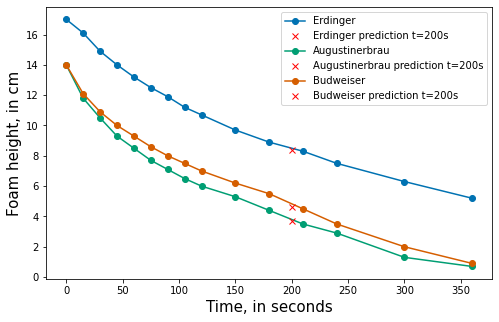

In [46]:
fig = plt.figure(figsize=(8,5))
for i in range(3):
    plt.plot(x, t[:,i],'-o',label=beers[i])
    plt.plot(200, predictions[i],'xr', label=beers[i]+ ' prediction t=200s')
plt.legend()
plt.xlabel('Time, in seconds', fontsize=15)
plt.ylabel('Foam height, in cm', fontsize=15);

### Observations

* The model choice also plays an important factor in the prediction. We know that the underlying model that characterizes foam height is an exponential model (as provided by the authors of this data set). 

* Let's try fitting a linear regression model over the logarithm transformation of the target value:

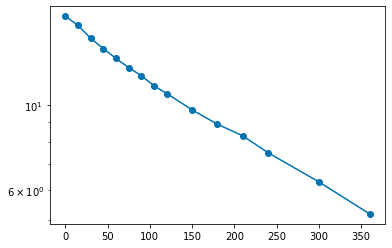

In [47]:
plt.plot(x, t[:,0],'-o')
plt.yscale('log');

In [48]:
t_log = np.log(t)

Now that we have transformed the desired label as the log, our goal is to fit a linear model to approximate:

\begin{align}
w_0 + w_1\mathbf{x}+\dots+w_M\mathbf{x}^M &= \ln(t) \\
\iff e^{w_0 + w_1\mathbf{x}+\dots+w_M\mathbf{x}^M} &= t
\end{align}

In [49]:
M = 1

w_erd, y_erd, e_erd = PolynomialRegression(x, t_log[:,0], M)
w_aug, y_aug, e_aug = PolynomialRegression(x, t_log[:,1], M)
w_bud, y_bud, e_bud = PolynomialRegression(x, t_log[:,2], M)

In [50]:
w_erd

array([ 2.78540725, -0.00322297])

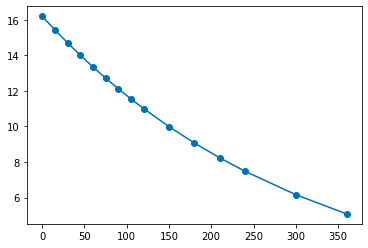

In [51]:
plt.plot(x, np.exp(w_erd[0] + w_erd[1]*x),'-o')

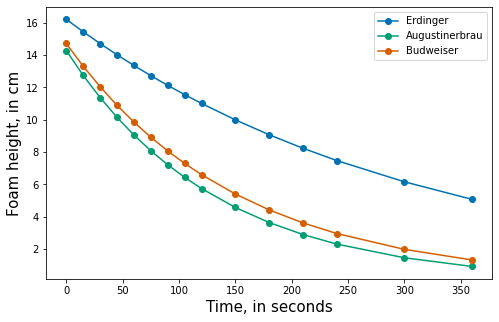

In [52]:
fig=plt.figure(figsize=(8,5))
plt.plot(x,np.exp(w_erd[0] + w_erd[1]*x),'-o', label='Erdinger')
plt.plot(x,np.exp(w_aug[0] + w_aug[1]*x),'-o', label='Augustinerbrau')
plt.plot(x,np.exp(w_bud[0] + w_bud[1]*x),'-o', label='Budweiser')
plt.legend()
plt.xlabel('Time, in seconds', fontsize=15)
plt.ylabel('Foam height, in cm', fontsize=15);

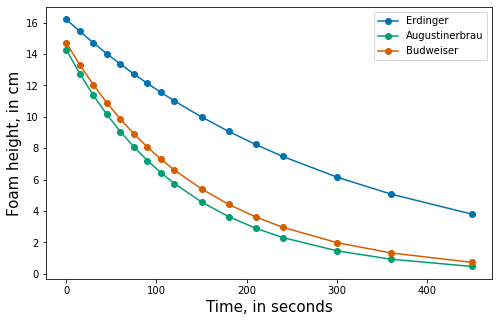

In [53]:
x2 = np.hstack((x,[450]))

fig=plt.figure(figsize=(8,5))
plt.plot(x2,np.exp(w_erd[0] + w_erd[1]*x2),'-o', label='Erdinger')
plt.plot(x2,np.exp(w_aug[0] + w_aug[1]*x2),'-o', label='Augustinerbrau')
plt.plot(x2,np.exp(w_bud[0] + w_bud[1]*x2),'-o', label='Budweiser')
plt.legend()
plt.xlabel('Time, in seconds', fontsize=15)
plt.ylabel('Foam height, in cm', fontsize=15);

# Experimental Design

**Motivation Question:** From the example of beer foam height, how to you select which ML model setting should you use?

* An ML model setting could simply be different parameter settings, such as different values for $M$ using the same model and features.
* But in general, "ML model setting" refers to the collection of choices for all steps in the training stage.

<div class="alert alert-info">
    <b>Experimental Design - How to use your data without cheating</b> 

In experimental design we need data to train (learn) models, and to test how good the models are. The training data needs to be different (disjoint) from the test data. Otherwise we would be testing the learned model on data it had previously seen, and we would get a biased estimate of the model's generalized performance.
    
Most machine learning algorithms require choosing parameter values; very often this is done by setting aside some of the training data to evaluate the quality of different parameter settings.
</div>

Typically we split the **training data** into three disjoint sets:
* **Training set**, 80\% - set of samples (and its labels) used to estimate the parameter values of the model (*learning the model*)
* **Validation set** - set of samples (and its labels) used for exploring and picking best parameter values
* **Test set**, typically 20\% - set of samples (and its labels) used for testing the model generalization performance, and testing hypotheses

1. The key thing to remember when planning experiments is that the test data is used to form conclusions but not to make decisions during model building. Basing decisions on test data results is frequently called *cheating* in the machine learning community, and often results in wrong conclusions.

2. Our generalization performance is only as good as our test set is representative of the true test data in application.

3. After all parameter value decisions have been made, we often use **ALL** training data for the final training of the system and deployment.

4. The training and validation sets may be rotated by using **cross-validation**.

### Beer Foam Example

Consider the beer foam example from earlier. Let's split it into training and test sets (for now, I will omit the validation set):

In [ ]:
idx_test = [i for j, i in enumerate(list(range(len(x)))) if j not in idx_train]

We can use the test set to compare the performance of the between the polynomial regression and linear regression of transformed output:

In [ ]:
# Polynomial Regression

M=3
w_pol,_,_= PolynomialRegression(xtrain, ttrain, M)
pred_pol = PolynomialRegression_test(xtest, M, w_pol)

print('LMS: ',np.sum((ttest-pred_pol)**2)/len(ttest))
print('Mean prediction error: ', np.mean(ttest-pred_pol))
print('Median prediction error: ', np.median(ttest-pred_pol))

In [ ]:
# Exponential Regression

M=3
w_exp, _,_ = PolynomialRegression(xtrain, np.log(ttrain), M)
pred_exp = np.exp(PolynomialRegression_test(xtest,M,w_exp))

print('LMS: ',np.sum((ttest-pred_exp)**2)/len(ttest))
print('Mean prediction error: ', np.mean(ttest-pred_exp))
print('Median prediction error: ', np.median(ttest-pred_exp))

**What happens if we sample a new training set?**

We cannot rely on one training run of the algorithm:
* Variations in training/validation sets
* random factors during training (e.g., random initialization, local optima, etc.)

<div class="alert alert-info">
    <b>No Free Lunch Theorem</b> 

The No Free Lunch Theorem states that there is no single learning algorithm that in any domain always induces the most accurate learner. The usual approach is to try many and choose the one that performs the best on a separate validation set.
    
For any learning algorithm, there is a dataset where it is very accurate and another dataset where it is very poor. When we say that a learning algorithm is good, we only quantify how well its inductive bias matches the properties of the data.
</div>

Performance of an algorithm can be determined using a variety of statistical measures. Some examples are: error rate, accuracy, ROC curves, performance-recall curves, etc.. But it can also be in terms of:
* Risk,
* Running time,
* Training time and storage/memory,
* Testing time and storage/memory,
* Interpretability, namely, whether the method allows knowledge extraction which can be checked and validated by experts, and
* computational complexity.

## Factors, Response, and Strategy of Experimentation

As in other branches of science and engineering, in machine learning too, we do experiments to get information about the process under scrutiny.

Our goal is to plan and conduct machine learning experiments and analyze the data resulting from the experiments, to be able to eliminate the effect of chance and obtain conclusions which we can consider *statistically significant*.

The output of a trained learning system depends on:
* **Controllable parameters:** hyper-parameters/settings of the algorithm/algorithm design choices

* **Uncontrollable parameters:** noise in data, any randomness in the training data

### Strategies of Experimentation

To fully test a system, you want to try to evaluate each of these parameters separately. However, this is often not easily done.

There are several *strategies of experimentation*:

![Experimentation](figures/Experimentation.png)

* Best guess
* One factor at a time
* Full/Partial Factorial design

### Principles of Experimental Design: Randomization, Replication, and Blocking

* **Randomization:** requires that the order in which the runs are carried out should be randomly determined so that the results are independent. For example, machines require some time to warm up until they operate in their normal range so tests should be done in random order for time not to bias the results.

* **Replication:** for the same configuration of (controllable) factors, the experiment should be run a number of times to average over the effect of uncontrollable factors and induced randomization. In machine learning, this is typically done by running the same algorithm on a number of resampled versions of the same dataset; this is known as **cross-validation**, which we will discuss soon.

* **Blocking:** is used to reduce or eliminate the variability due to nuisance factors that influence the response but in which we are not interested. For example, defects produced in a factory may also depend on the different batches of raw material, and this effect should be isolated from the controllable factors in the factory, such as the equipment, personnel, and so on. In ML experimentation, when we use resampling and use different subsets of the data for different replicates, we need to make sure that for example if we are comparing learning algorithms, they should all use the same set of resampled subsets.

### Guidelines for ML Experiments

Before we start experimentation, we need to have a good idea about what it is we are studying, how the data is to be collected, and how we are planning to analyze it.

1. Understand the goal of the study
2. Determine your evaluation metric(s)
3. Determine what factors to vary and how to vary them
4. Design your experiment (and get an estimate of how long it will take using a couple trial runs)
5. Perform the experiment
6. Analyze the result by performing statistical analysis
7. Draw your conclusions based on your design and result